<a href="https://colab.research.google.com/github/galalqassas/xai/blob/main/notebooks/DNN/Mohamed_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [317]:
%%capture
!pip install -q lime shap
!pip install PyALE
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

In [291]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split, learning_curve, ValidationCurveDisplay
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, auc, PrecisionRecallDisplay
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.utils import _safe_indexing
import warnings
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
import time
from lime import lime_tabular
import shap
from PyALE import ale
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.metrics import average_precision_score, make_scorer
import dice_ml
warnings.filterwarnings('ignore')

# **Utils**

In [308]:
def dnn_confusion_matrix(model, X_train, y_train, X_test, y_test, model_name='DNN Model'):
    y_train_pred = (model.predict(X_train) > 0.5).astype(int).ravel()
    y_test_pred = (model.predict(X_test) > 0.5).astype(int).ravel()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    ConfusionMatrixDisplay.from_predictions(
        y_train, y_train_pred,
        cmap="Blues", ax=ax1
    )
    ax1.set_title(f"{model_name} - Training Confusion Matrix")
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_test_pred,
        cmap="Blues", ax=ax2
    )
    ax2.set_title(f"{model_name} - Test Confusion Matrix")
    plt.suptitle(f"{model_name} Confusion Matrices", fontsize=16)
    plt.tight_layout()
    plt.show()

def our_roc(model, name="Model"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    roc1 = RocCurveDisplay.from_estimator(
    model, X_train, y_train,
    name=name, ax=ax1,
    color="orange" #juicy juicy
    )
    roc2 = RocCurveDisplay.from_estimator(
        model, X_test, y_test,
        name=name, ax=ax2,
        color="orange" #juicy juicy
    )
    ax1.fill_between(roc1.fpr, roc1.tpr, alpha=0.4, color="orange")
    ax2.fill_between(roc2.fpr, roc2.tpr, alpha=0.4, color="orange")
    ax1.set_title(f"{name} Training ROC Curve", fontsize=16)
    ax2.set_title(f"{name} Testing ROC Curve", fontsize=16)
    for ax in [ax1, ax2]:
        ax.grid(alpha=0.5)

def our_learning_curve(model, name='Model'):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=0
    )

    plt.figure(figsize=(13, 8))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="mediumseagreen", label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="royalblue", label="Cross-validation score")
    plt.title(f"{name} Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid(alpha=0.5)

def our_prc(model, name="Model"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 13))
    train_disp = PrecisionRecallDisplay.from_estimator(model, X_train, y_train, ax=ax1, color='orange')
    test_disp = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax2, color='orange')
    ax1.set_title(f"{name} Precision-Recall Curve - Train")
    ax2.set_title(f"{name} Precision-Recall Curve - Test")
    ax1.fill_between(train_disp.recall, train_disp.precision, alpha=0.4, color='orange')
    ax2.fill_between(test_disp.recall, test_disp.precision, alpha=0.4, color='orange')


def plot_dnn_lime_explanation(dnn_model, instance_scaled, instance_original, lime_explainer, feature_names, class_names, true_label=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    pred_probas = predict_proba_for_lime(instance_scaled.reshape(1, -1))[0]
    pred_class_index = np.argmax(pred_probas)
    pred_class_name = class_names[pred_class_index]
    pred_probability = pred_probas[pred_class_index]
    prediction_text = f"Predicted: {pred_class_name} ({pred_class_index}) ({pred_probability:.2f})"
    true_label_text = ""
    if true_label is not None:
        true_label_name = class_names[int(true_label)]
        true_label_text = f"True Label: {true_label_name} ({int(true_label)})"

    exp = lime_explainer.explain_instance(
        data_row=instance_scaled,
        predict_fn=predict_proba_for_lime,
        num_features=10
    )

    if isinstance(instance_original, pd.Series):
        display_values = instance_original.values
        display_index = instance_original.index
    else:
        display_values = instance_original
        display_index = feature_names
    if len(display_index) != len(display_values):
         print("Mismatch between feature names/index and instance values for plot.")
         if len(feature_names) == len(display_values):
             display_index = feature_names
         else:
             display_index = range(len(display_values))

    ax1.barh(display_index, display_values, color='skyblue')
    ax1.set_title('Feature Values (Original Scale)')
    ax1.set_xlabel('Value')
    ax1.invert_yaxis()

    lime_features_list = exp.as_list()
    if lime_features_list:
        features = [f[0] for f in lime_features_list]
        contributions = [f[1] for f in lime_features_list]
        colors = ['green' if c > 0 else 'red' for c in contributions]

        ax2.barh(features, contributions, color=colors)
        ax2.axvline(0, color='black', linestyle='--')
    else:
         ax2.text(0.5, 0.5, "LIME explanation failed or returned empty.",
                  ha='center', va='center', transform=ax2.transAxes)

    ax2.set_title(f'LIME Explanation\n{prediction_text}\n{true_label_text}')
    ax2.set_xlabel(f'Contribution to "{pred_class_name}" Prediction')
    ax2.invert_yaxis()
    plt.tight_layout(pad=2.0)
    plt.show()

def predict_proba_for_lime(data_np):
    data_np = np.array(data_np, dtype=np.float32)
    probabilities = DNN_model.predict(data_np)
    if probabilities.shape[1] == 1:
        return np.hstack([1 - probabilities, probabilities])
    else:
        return probabilities

# **Load Processed Dat**a

In [ ]:
path = kagglehub.dataset_download('mohamedhassan77/xai-project-processed-data')
df = pd.read_csv(f"{path}/combined_adasyn_train_test.csv")
df

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,promotion_velocity,workload_score,compensation_ratio,Attrition,Set
0,31,2,1062,1,24,3,3,3,0,96,...,3,10.0,9,1,8,9.999900,1,1.019760,0,Train
1,50,2,328,1,1,3,3,3,1,86,...,2,3.0,2,0,2,300000.000000,2,1.281918,0,Train
2,46,2,717,1,13,4,1,3,1,34,...,3,10.0,7,0,9,1000000.000000,1,0.832635,0,Train
3,44,2,170,1,1,4,1,2,1,78,...,3,2.0,0,2,2,0.999995,1,0.753443,0,Train
4,26,1,1479,1,1,3,1,3,0,84,...,1,6.0,5,1,4,5.999940,3,1.007878,0,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2042,56,2,1162,1,24,2,1,1,1,97,...,3,4.0,2,1,0,3.999960,1,0.898732,1,Test
2043,46,2,669,2,9,2,3,3,1,64,...,3,9.0,8,4,7,2.249994,1,1.558490,1,Test
2044,30,2,1240,0,9,3,0,3,1,48,...,1,11.0,9,4,7,2.749993,7,2.052053,0,Test
2045,31,2,741,1,2,4,1,2,1,69,...,4,5.0,2,0,3,500000.000000,0,1.207921,0,Test


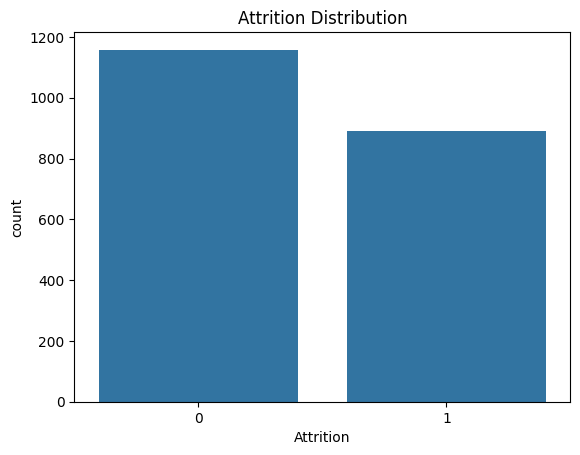

In [ ]:
sns.countplot(x='Attrition', data=df)
plt.title('Attrition Distribution')
plt.show()

In [ ]:
train_df = df[df['Set'] == 'Train'].drop(columns=['Set'])
test_df = df[df['Set'] == 'Test'].drop(columns=['Set'])

X_train = train_df.drop(columns=['Attrition'])
y_train = train_df['Attrition']

X_test = test_df.drop(columns=['Attrition'])
y_test = test_df['Attrition']

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (1589, 33) y_train: (1589,)
X_test: (458, 33) y_test: (458,)


# **Model-Specific EDA (Optional)**

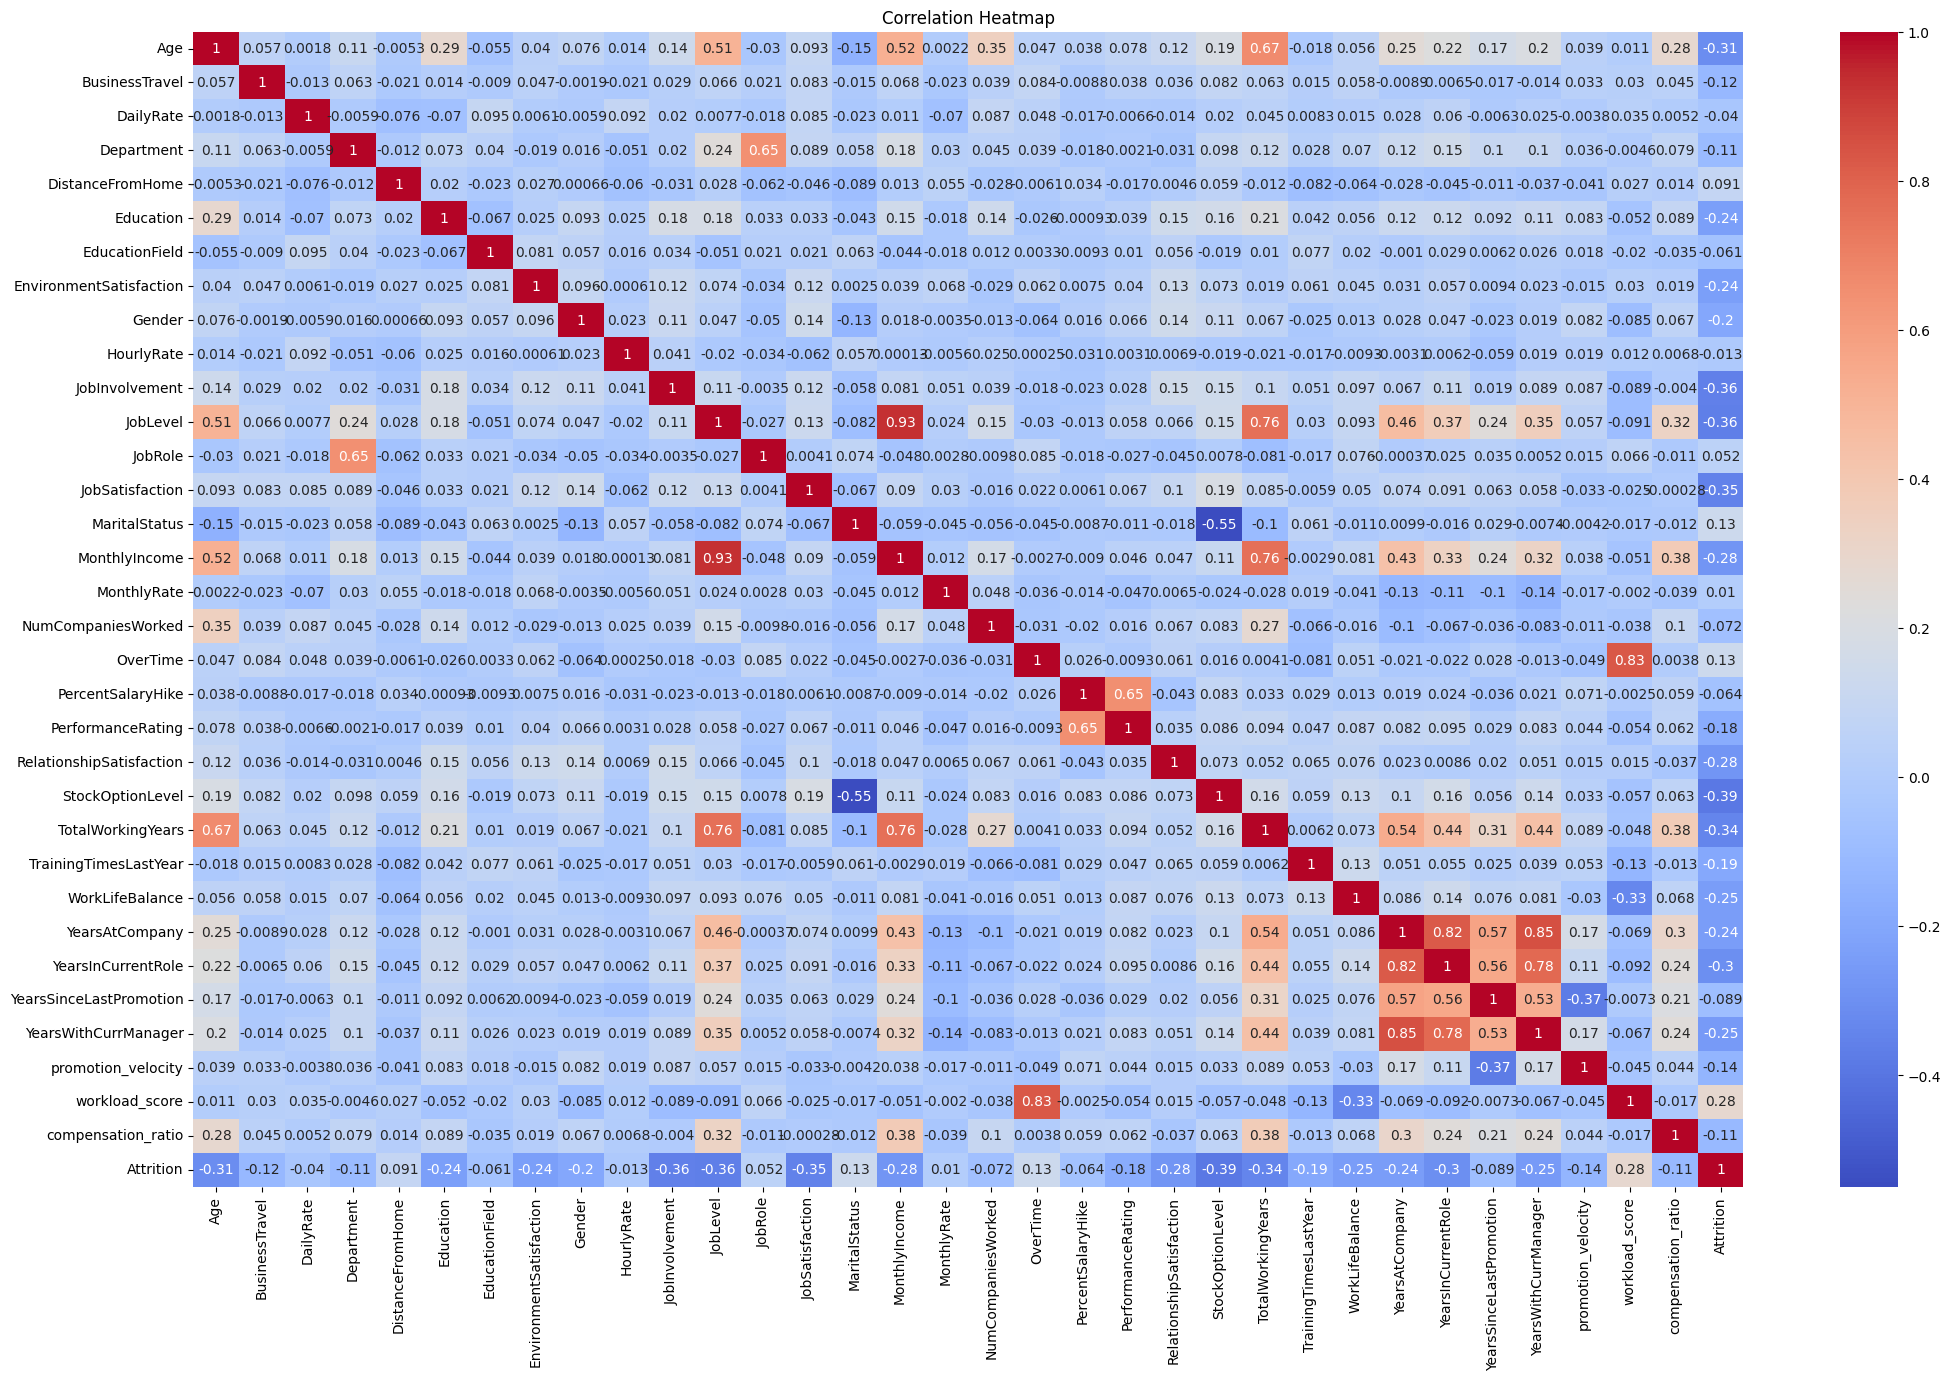

In [ ]:
corr = train_df.corr()
plt.figure(figsize=(25, 15))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
chi2_values, p_values = chi2(X_train, y_train)
chi2_results = pd.DataFrame({
    'Feature': X_train.columns,
    'Chi2 Value': chi2_values,
    'p-Value': p_values
})

chi2_results = chi2_results.sort_values(by='Chi2 Value', ascending=False)
print(chi2_results)

                     Feature    Chi2 Value        p-Value
30        promotion_velocity  1.483580e+07   0.000000e+00
15             MonthlyIncome  3.455632e+05   0.000000e+00
23         TotalWorkingYears  8.154713e+02  2.335363e-179
16               MonthlyRate  5.695704e+02  6.962546e-126
2                  DailyRate  4.454893e+02   6.914930e-99
27        YearsInCurrentRole  4.097537e+02   4.146999e-91
0                        Age  3.212948e+02   7.565872e-72
26            YearsAtCompany  3.119207e+02   8.333204e-70
29      YearsWithCurrManager  2.942043e+02   6.032466e-66
22          StockOptionLevel  2.653632e+02   1.162791e-59
31            workload_score  1.622073e+02   3.727346e-37
11                  JobLevel  1.085899e+02   1.995881e-25
13           JobSatisfaction  9.473971e+01   2.171387e-22
4           DistanceFromHome  8.009254e+01   3.572791e-19
21  RelationshipSatisfaction  5.726754e+01   3.803820e-14
10            JobInvolvement  4.413856e+01   3.059349e-11
28   YearsSinc

In [ ]:
# Scaling data
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **Model Initialization**

same structure used in the paper

In [ ]:
input_shape = X_train_scaled.shape[1]

def build_dnn_model(input_shape):
    model = keras.Sequential(name="Attrition_DNN")
    model.add(layers.InputLayer(input_shape=(input_shape,)))

    # 7 Hidden Layers with Softplus activation
    for i in range(7):
        model.add(layers.Dense(100, activation='softplus', name=f'hidden_layer_{i+1}'))

    # Output Layer with Sigmoid activation
    model.add(layers.Dense(1, activation='sigmoid', name='output_layer'))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
DNN_model = build_dnn_model(input_shape)
DNN_model.summary()

Model: "Attrition_DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 100)            │         3,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_4 (Dense)          │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_5 (Dense)          │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_6 (Dense)          │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_7 (Dense)          │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,101 (250.39 KB)

 Trainable params: 64,101 (250.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# balance class weights
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, weights))

print("Calculated Class Weights:", class_weight_dict)

Calculated Class Weights: {np.int64(0): np.float64(1.0121019108280256), np.int64(1): np.float64(0.9881840796019901)}


# **Model Training**

In [ ]:
start_time = time.time()
history = DNN_model.fit(X_train_scaled, y_train,
                            epochs=100,
                            batch_size=32,
                            validation_split=0.2,
                            class_weight=class_weight_dict)
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5929 - loss: 0.6781 - val_accuracy: 0.0000e+00 - val_loss: 1.0086
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6103 - loss: 0.6654 - val_accuracy: 0.0000e+00 - val_loss: 0.8330
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6182 - loss: 0.6692 - val_accuracy: 0.0000e+00 - val_loss: 0.8822
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6665 - loss: 0.5782 - val_accuracy: 0.6824 - val_loss: 0.6518
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8438 - loss: 0.3888 - val_accuracy: 0.5629 - val_loss: 0.8027
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8231 - loss: 0.4087 - val_accuracy: 0.8994 - val_loss: 0.2361
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8158 - loss: 0.4049 - val_accuracy: 0.9057 - val_loss: 0.2393
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8342 - loss: 0.3768 - val_accurac

# **Model Evaluation**

In [ ]:
y_pred_probs = DNN_model.predict(X_test_scaled)
y_pred_classes = (y_pred_probs > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_test, y_pred_classes))

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy: 0.8165938864628821

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89       373
           1       0.51      0.48      0.49        85

    accuracy                           0.82       458
   macro avg       0.69      0.69      0.69       458
weighted avg       0.81      0.82      0.81       458



### Val - Loss Curve

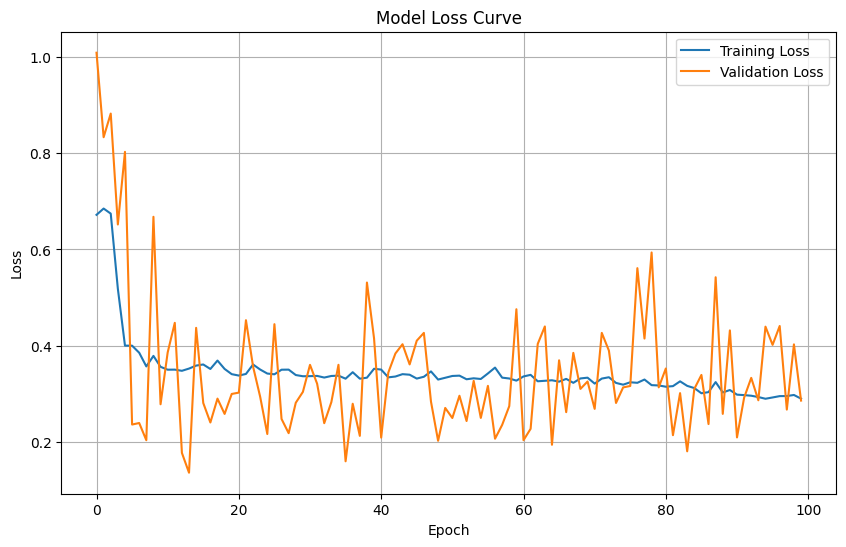

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

*   **Training Loss (Blue Line):** Decreases rapidly in the initial epochs and then become nearly flat for the rest of the training. This indicates the model stopped improving significantly on the training data itself in early phase.
*   **Validation Loss (Orange Line):** Starts high, drops quickly, but then exhibits **high volatility** throughout the remaining epochs. It frequently spikes and dips, oscillating significantly around the training loss level without settling into a consistent downward trend.
*   **Comparison:** There isn't a large growing gap to say there is overfitting. but the primary issue highlighted by this curve is the **instability of the validation loss** suggesting the model struggled to find a stable set of weights that can generalize well to the unseen data.

### Confusion Matrix

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


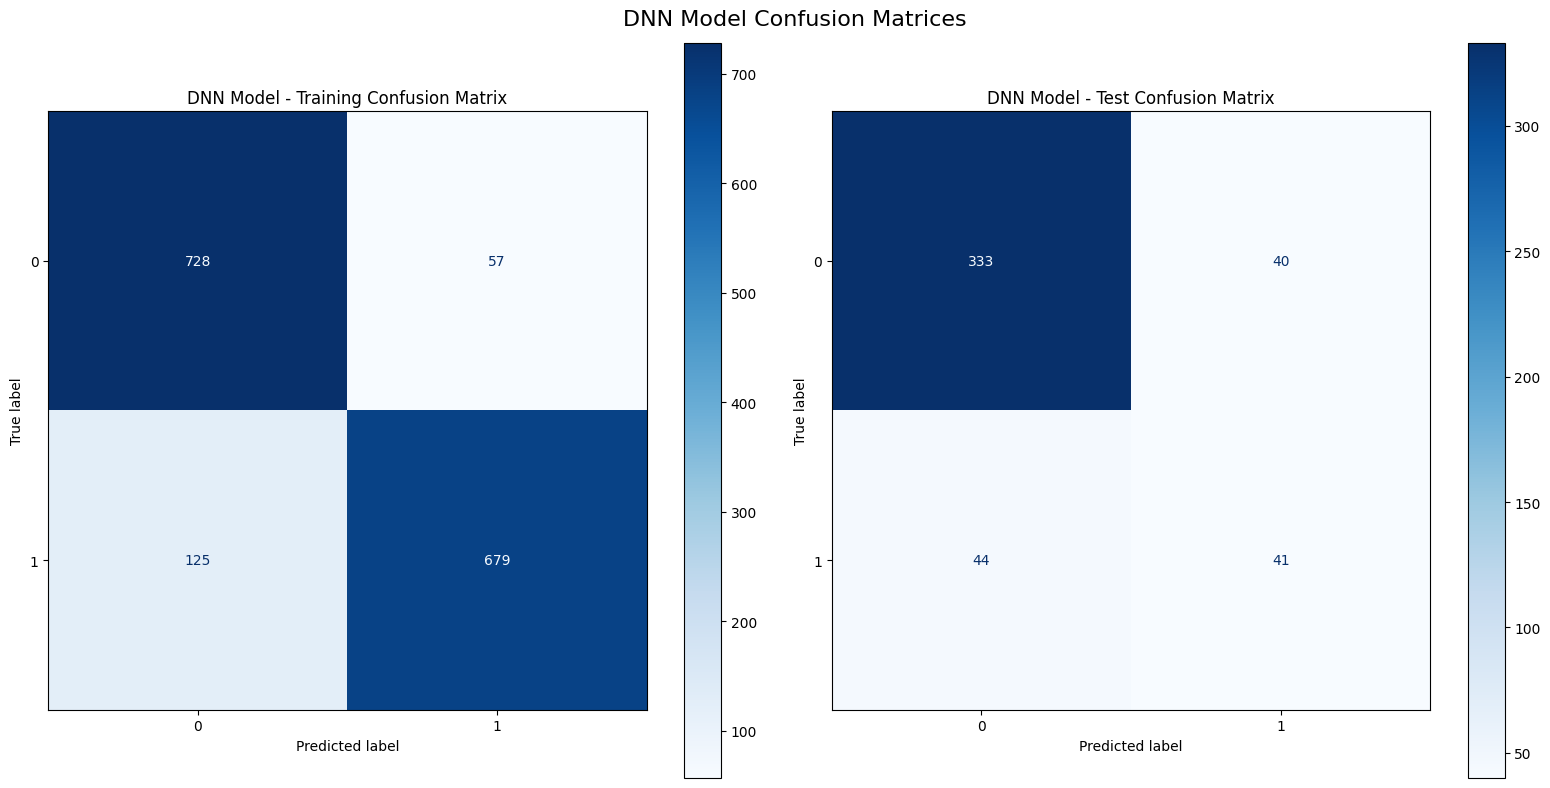

In [ ]:
dnn_confusion_matrix(
    model=DNN_model,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test
)

**Training Confusion Matrix**
* **Class 0 (No Attrition):**
    * Correctly predicted 728/785 (True Negatives) -> High accuracy for "stayers".
    * Misclassified 125/785 as Class 1 (False Positives).
* **Class 1 (Attrition):**
    * Correctly predicted 679/736 (True Positives) -> Strong performance for "leavers".
    * Misclassified 57/736 as Class 0 (False Negatives).

The model performs well on both classes during training.

**Test Confusion Matrix**
* **Class 0 (No Attrition):**
    * Correctly predicted 333/373 (True Negatives) → Still reliable for "stayers".
    * Misclassified 40/373 as Class 1 (False Positives).
* **Class 1 (Attrition):**
    * Correctly predicted 41/85 (True Positives) → Poor performance for "leavers".
    * Misclassified 44/85 as Class 0 (False Negatives).

The model struggles significantly with Class 1 (Attrition) on unseen data, indicating overfitting to the training set and a bias toward cLass 0 (No Attrition).

# **Explainability Techniques**

## LIME

In [315]:
feature_names = X_train.columns.tolist()
class_names = ['No', 'Yes']

lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification',
    discretize_continuous=True
)

instance_index = 20

instance_to_explain = X_test_scaled[instance_index]
original_instance_values = X_test.iloc[instance_index]
exp = lime_explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=predict_proba_for_lime,
    num_features=10
)

pred_proba_instance = predict_proba_for_lime(instance_to_explain.reshape(1, -1))[0]
pred_class_index = np.argmax(pred_proba_instance)
pred_class_name = class_names[pred_class_index]
pred_probability = pred_proba_instance[pred_class_index]

if isinstance(y_test, pd.Series):
    true_label_index = y_test.iloc[instance_index]
else:
    true_label_index = y_test[instance_index]
true_label_name = class_names[int(true_label_index)]

prediction_text = f"Predicted: {pred_class_name} ({pred_class_index}) ({pred_probability:.2f})"
true_label_text = f"True Label: {true_label_name} ({int(true_label_index)})"
print(prediction_text)
print(true_label_text)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Predicted: No (0) (0.97)
True Label: No (0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


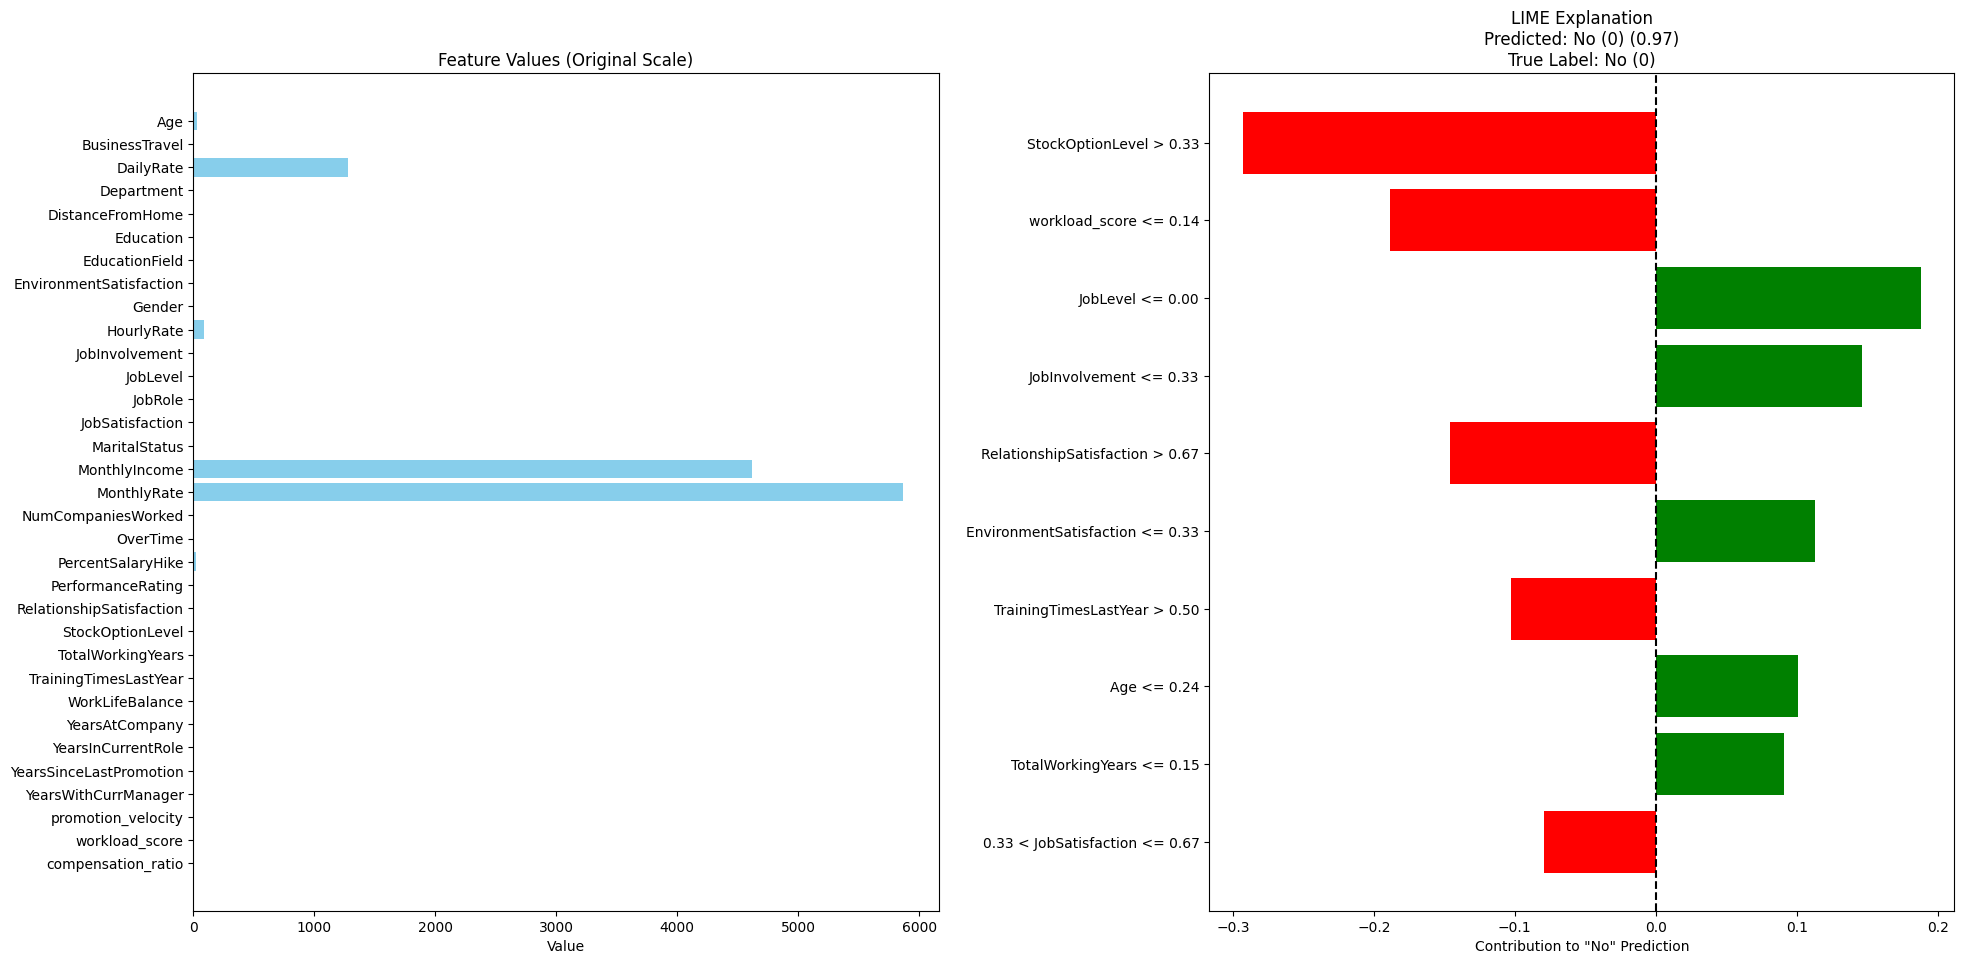

In [316]:
instance_index_to_plot = 20
if isinstance(X_test_scaled, pd.DataFrame):
    instance_s = X_test_scaled.iloc[instance_index_to_plot].values
else:
    instance_s = X_test_scaled[instance_index_to_plot]


instance_o = X_test.iloc[instance_index_to_plot]

if isinstance(y_test, pd.Series):
    true_l = y_test.iloc[instance_index_to_plot]
else:
    true_l = y_test[instance_index_to_plot]

plot_dnn_lime_explanation(
    dnn_model=DNN_model,
    instance_scaled=instance_s,
    instance_original=instance_o,
    lime_explainer=lime_explainer,
    feature_names=feature_names,
    class_names=class_names,
    true_label=true_l
)

* **Top Key Drivers Towards “No Attrition” (Green Bars):**
These features increased the model's confidence that the employee will stay (class 0 = No Attrition):
    * JobLevel <= 0.00
    * JobInvolvement <= 0.33
    * EnvironmentSatisfaction <= 0.33
    * Age <= 0.24
    * TotalWorkingYears <= 0.15

* **Top Key Drivers Towards “Attrition” (Red Bars):**
These features pushed the model away from predicting class 0 (retention) they supported attrition:

    * StockOptionLevel > 0.33

    * workload_score <= 0.14

    * RelationshipSatisfaction > 0.67

    * TrainingTimesLastYear > 0.50

    * 0.33 < JobSatisfaction <= 0.67

While the prediction is correct there are some **counter-intuitive** interpretations. Some factors typically associated with higher attrition risk (low job level, low satisfaction, low age/tenure) are appear as reasons for retention, while factors often linked to retention (high stock options, high relationship satisfaction) are appear pushing towards attrition. This suggests the model's reasoning for this correct prediction might be flawed or poorly captured by the local LIME approximation.

## SHAP Analysis

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

explainer = shap.Explainer(DNN_model, X_train_scaled_df)
shap_vals = explainer(X_test_scaled_df)

PermutationExplainer explainer: 459it [04:02,  1.81it/s]


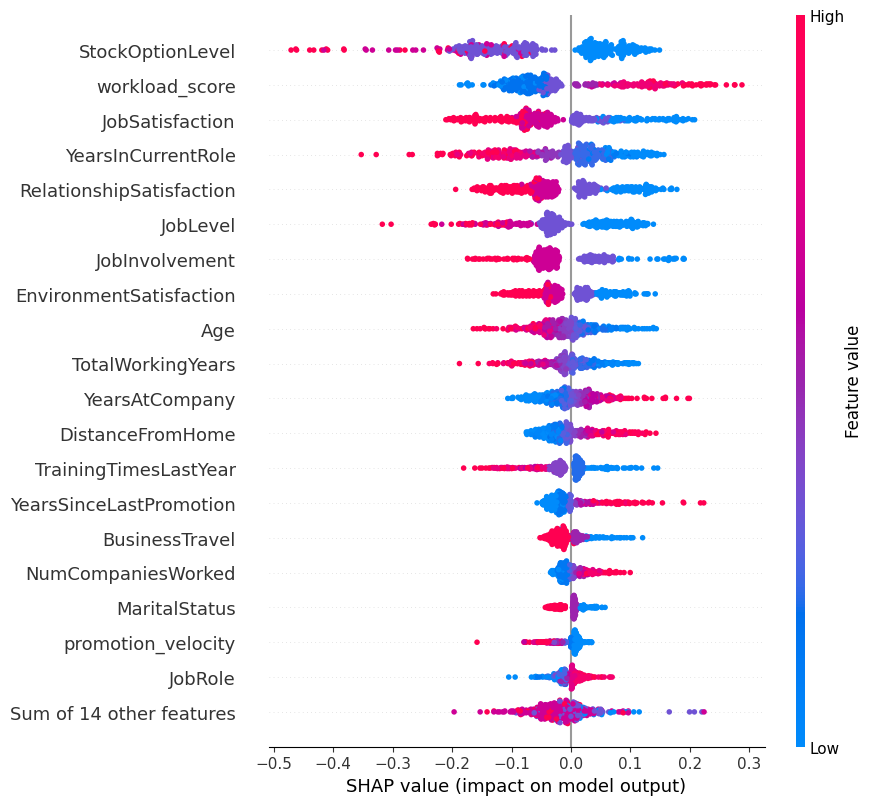

In [ ]:
shap.plots.beeswarm(
    shap_vals,
    max_display=20
)

Features like `StockOptionLevel`, `workload_score`, and `JobSatisfaction` are most important overall. Generally, low stock options/satisfaction or high workload push towards predicting Attrition (positive SHAP), while high stock options/satisfaction or low workload push towards No Attrition (negative SHAP).

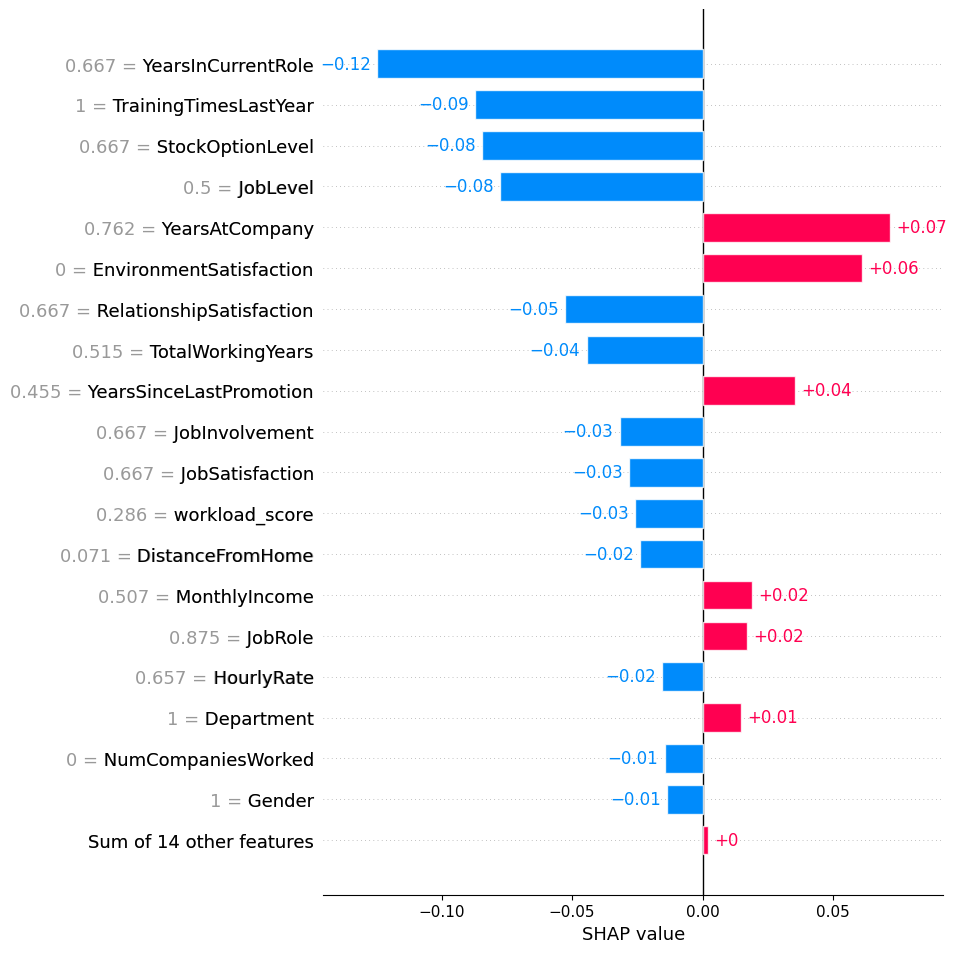

In [ ]:
shap.plots.bar(
    shap_vals[1],
    max_display=20
)

For this single instance (index = 1), the prediction is pushed towards No Attrition most strongly by high `YearsInCurrentRole`, high `TrainingTimesLastYear`, high `StockOptionLevel`, and high `JobLevel`. Factors pushing the prediction towards Attrition are high `YearsAtCompany`, low `EnvironmentSatisfaction`, and more `YearsSinceLastPromotion`.

## Accumulated Local Effects (ALE)

In [ ]:
class ProbaWrapper:
    def __init__(self, m):
         self.m = m
    def predict(self, X):
         X_np = np.array(X)
         return self.m.predict(X_np)[:,0]
pw = ProbaWrapper(DNN_model)

INFO:PyALE._ALE_generic:Continuous feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


INFO:PyALE._ALE_generic:Discrete feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


INFO:PyALE._ALE_generic:Continuous feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


INFO:PyALE._ALE_generic:Discrete feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


INFO:PyALE._ALE_generic:Continuous feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


INFO:PyALE._ALE_generic:Discrete feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


INFO:PyALE._ALE_generic:Discrete feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


INFO:PyALE._ALE_generic:Discrete feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


INFO:PyALE._ALE_generic:Continuous feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


INFO:PyALE._ALE_generic:Discrete feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


INFO:PyALE._ALE_generic:Discrete feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


INFO:PyALE._ALE_generic:Discrete feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


INFO:PyALE._ALE_generic:Discrete feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


INFO:PyALE._ALE_generic:Discrete feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


INFO:PyALE._ALE_generic:Continuous feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


INFO:PyALE._ALE_generic:Continuous feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


INFO:PyALE._ALE_generic:Discrete feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


INFO:PyALE._ALE_generic:Continuous feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


INFO:PyALE._ALE_generic:Discrete feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


INFO:PyALE._ALE_generic:Discrete feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


INFO:PyALE._ALE_generic:Continuous feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


INFO:PyALE._ALE_generic:Discrete feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


INFO:PyALE._ALE_generic:Discrete feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


INFO:PyALE._ALE_generic:Continuous feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


INFO:PyALE._ALE_generic:Continuous feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


INFO:PyALE._ALE_generic:Continuous feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


INFO:PyALE._ALE_generic:Continuous feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


INFO:PyALE._ALE_generic:Continuous feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


INFO:PyALE._ALE_generic:Discrete feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


INFO:PyALE._ALE_generic:Continuous feature detected.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


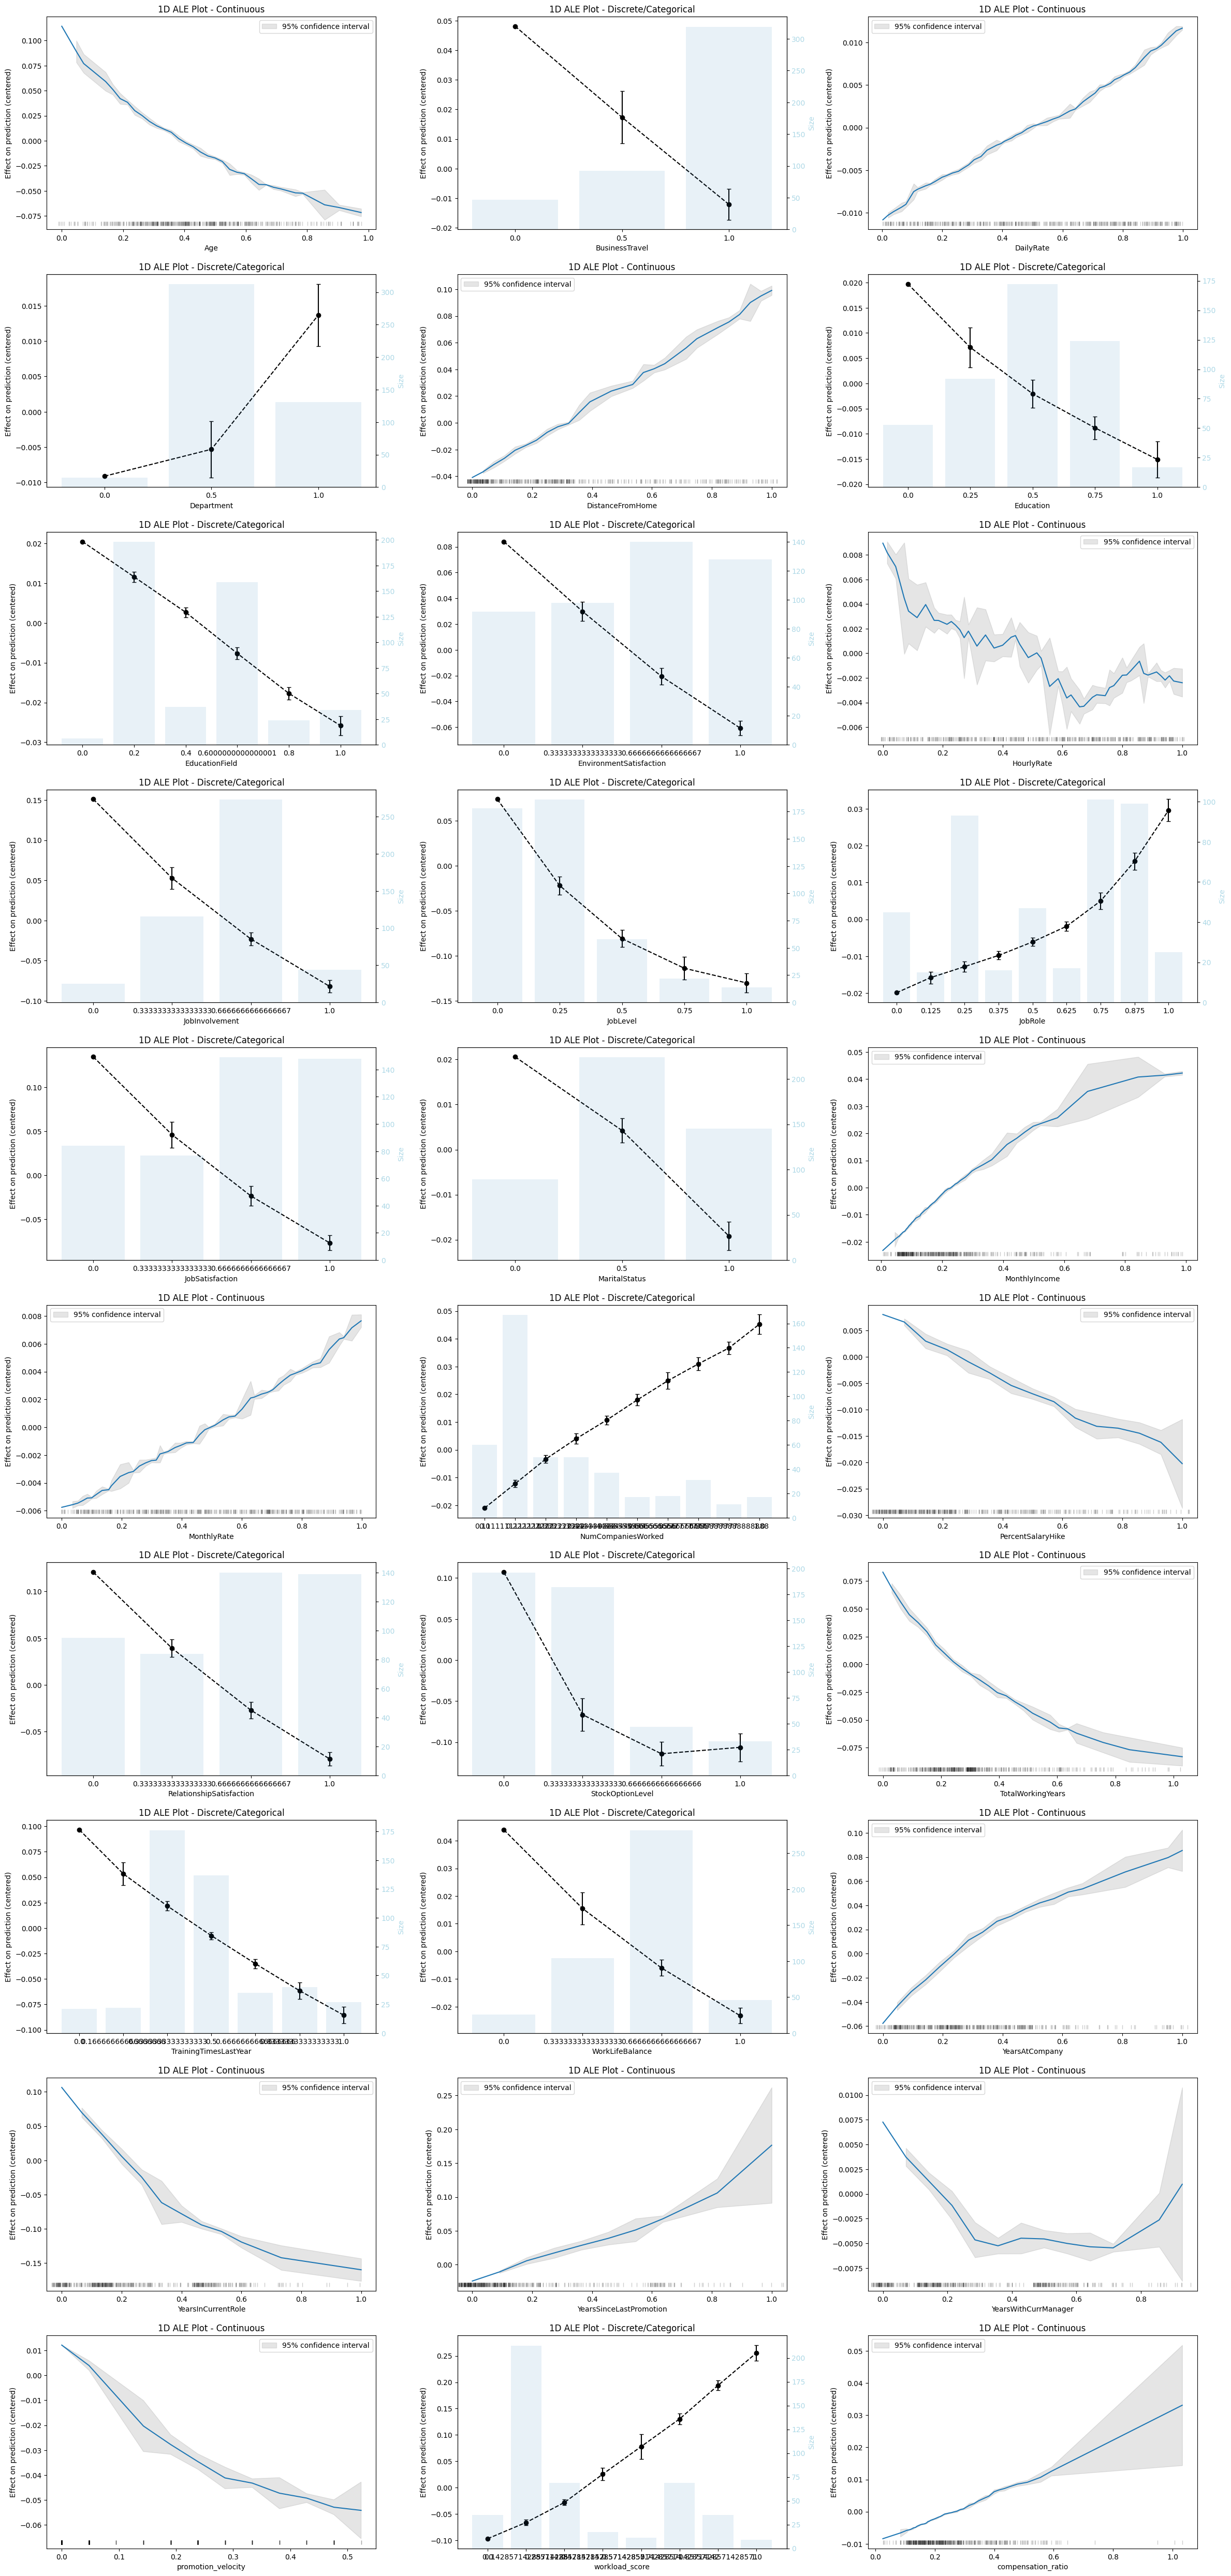

In [ ]:
cont = [c for c in X_test_scaled_df.columns if X_test_scaled_df[c].nunique() > 2]
n_cols = 3
n_rows = (len(cont) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 5 * n_rows))
axes = axes.flatten()

for i, feat in enumerate(cont):
    current_ax = axes[i]
    ale_eff = ale(
        X=X_test_scaled_df,
        model=pw,
        feature=[feat],
        grid_size=50,
        include_CI=True,
        C=0.95,
        fig=fig,
        ax=current_ax)

for j in range(len(cont), len(axes)):
    axes[j].set_visible(False)

plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.tight_layout(pad=1.5)
plt.show()

*   **Strong Negative Effects (Reducing Attrition Risk):** Higher `JobSatisfaction`, `EnvironmentSatisfaction`, `RelationshipSatisfaction`, `JobInvolvement`, and `WorkLifeBalance` strongly decrease the predicted risk. Older `Age`, longer `TotalWorkingYears` / `YearsInCurrentRole`, and having (`StockOptionLevel` > 0) also significantly lower the risk on average.
*   **Strong Positive Effects (Increasing Attrition Risk):** Increased `DistanceFromHome`, `NumCompaniesWorked`, higher `workload_score`, and higher `MonthlyIncome` increase the average predicted risk according to ALE.
*   **Weaker/Variable Effects:** Features like `DailyRate`, `HourlyRate`, `MonthlyRate`, and `PercentSalaryHike` show relatively flatter or more variable effects, suggesting their isolated main impact is less consistent or strong.

The counter-intuitive positive effect observed for `MonthlyIncome` in its ALE plot likely reflects its isolated main effect after accounting for correlations, suggesting that its commonly perceived negative association with attrition risk might be largely driven by correlated factors.

## Permutation Feature Importance (PFI)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


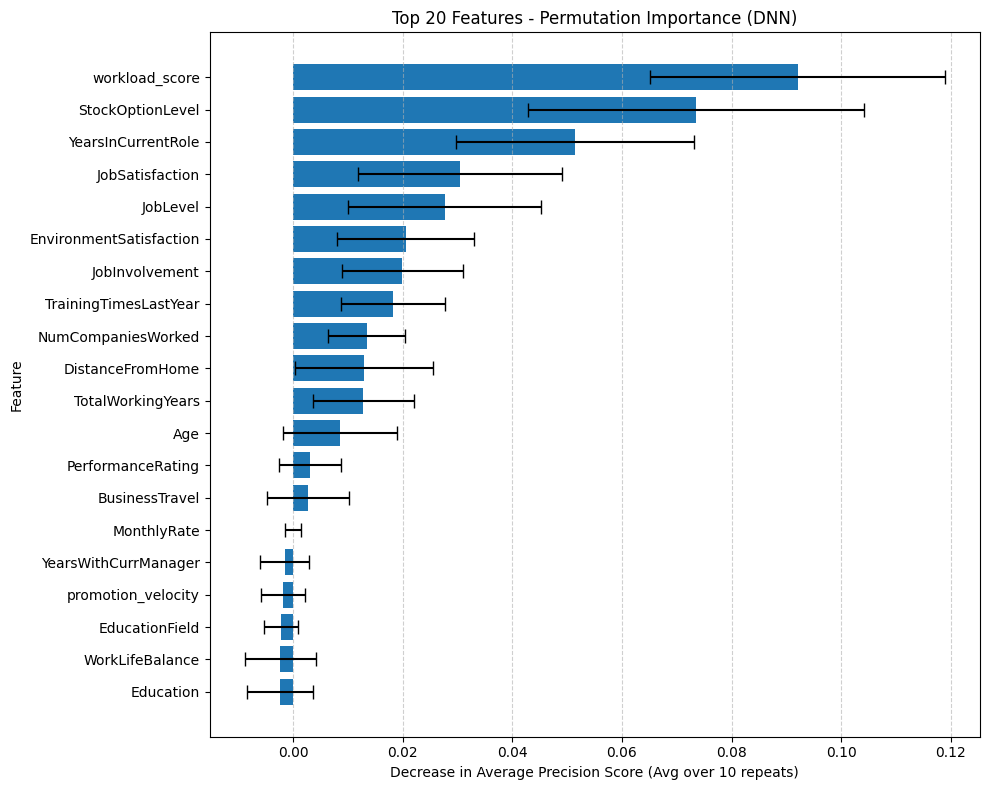

In [272]:
feature_names = X_train.columns.tolist()
def average_precision_scorer(model, X, y_true):
    y_pred_proba = model.predict(X)[:, 0]
    return average_precision_score(y_true, y_pred_proba)

n_repeats = 10
X_test_pfi = X_test_scaled.values if isinstance(X_test_scaled, pd.DataFrame) else X_test_scaled
y_test_pfi = y_test.values if isinstance(y_test, pd.Series) else y_test

result = permutation_importance(
    estimator=DNN_model,
    X=X_test_pfi,
    y=y_test_pfi,
    scoring=average_precision_scorer,
    n_repeats=n_repeats,
    random_state=42,
    n_jobs=-1
)

importances_mean = result.importances_mean
importances_std = result.importances_std

perm_importance_df = pd.Series(importances_mean, index=feature_names)
perm_importance_df = perm_importance_df.sort_values(ascending=False)

sorted_indices = perm_importance_df.index
sorted_std = importances_std[np.argsort(importances_mean)[::-1]]


n_plot_features = 20
plt.figure(figsize=(10, n_plot_features / 2.5))
top_importance = perm_importance_df[:n_plot_features]
top_std = sorted_std[:n_plot_features]

plt.barh(top_importance.index[::-1], top_importance.values[::-1],
         xerr=top_std[::-1], align='center', capsize=5)
plt.xlabel(f"Decrease in Average Precision Score (Avg over {n_repeats} repeats)")
plt.ylabel("Feature")
plt.title(f"Top {n_plot_features} Features - Permutation Importance (DNN)")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Permutation feature importance (PFI) measures the increase in the prediction error of the model after shuffling the values of the feature showing us the relation between the feature and true outcome.
* From the plot it apears that `workload_score`, `StockOptionLevel` and `YearsInCurrentRole` have the highest effect (highest importance).